In [1]:
import json
import itertools

import joblib
import numpy as np
import pandas as pd
from upath import UPath as Path

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from skops.io import dump
from skops.io import load
import skops.io as sio

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as colors
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [3]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 10


In [4]:
files_dir = Path("/Users/ewheeler/dev/UNDatathon/data/gdelt_files/")

In [5]:
def one_hot(df, cols):
    """ One-hot encode given `cols` and add as new columns
        to `df`
        
        Returns tuple of `df` with new columns and list of
        new column names.
    """
    new_cols = list()
    new_col_names = list()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        new_cols.append(dummies)
        new_col_names.append(dummies.columns.values)

    df = pd.concat([df]+new_cols, axis=1)
    new_col_names = list(itertools.chain.from_iterable(new_col_names))
    return df, new_col_names

In [6]:
#target_countries_iso = ['BDI', 'ZWE', 'MUS', 'COM', 'SOM', 'MOZ', 'SSD', 'MDG', 'SYC',
#                        'ZMB', 'DJI', 'KEN', 'TZA', 'ETH', 'UGA', 'UKR', 'RWA', 'MWI',
#                        'EGY', 'RUS', 'REU']

In [7]:
target_countries_iso = ['UKR', 'DJI', 'EGY', 'KEN', 'MOZ', 'SDN', 'TZA', 'RUS']

In [8]:
country_iso = 'SDN'

## Data preparation

In [9]:
_df = pd.read_feather(files_dir / 'gdelt_monthly_fpi.feather').query(f"iso3 == '{country_iso}'")
_df

,iso3,Date,timelinetone_orig,timelinetone,timelinevol_orig,timelinevol,fpi,fpi_orig
key,,,,,,,,
2019-01-01_SDN,SDN,2019-01-01,-39.0412,12.299257,0.0184,-15.803090,-0.750266,61.360641
2019-02-01_SDN,SDN,2019-02-01,-79.5541,-7.614472,0.0141,-16.280752,-0.740594,62.041995
2019-03-01_SDN,SDN,2019-03-01,-53.5858,6.150716,0.0143,-19.069272,-0.746508,61.625377
2019-04-01_SDN,SDN,2019-04-01,-70.7977,-2.054533,0.0112,-20.556208,-0.737791,62.239464
2019-05-01_SDN,SDN,2019-05-01,-46.8292,9.006981,0.0127,-20.343879,-0.798728,57.946533
2019-06-01_SDN,SDN,2019-06-01,-60.8712,2.141766,0.0100,-21.512164,-0.764072,60.388029
2019-07-01_SDN,SDN,2019-07-01,-18.0825,21.159275,0.0137,-19.547250,-0.718590,63.592111
2019-08-01_SDN,SDN,2019-08-01,-65.3376,1.182796,0.0124,-20.582868,-0.742270,61.923927
2019-09-01_SDN,SDN,2019-09-01,-38.1210,11.759117,0.0093,-22.069805,-0.756079,60.951124


In [10]:
countries_hash = joblib.hash(_df['iso3'].unique())

In [11]:
_df.shape

(54, 8)

In [12]:
if _df['iso3'].nunique() > 1:
    df_oh, oh_cols = one_hot(_df, ['iso3'])
    df_oh = df_oh.drop(columns=['iso3'])
    df_oh.columns.values
else:
    oh_cols = None

In [13]:
# in the eda notebook, all original values were scaled for each country.
# to avoid leaking data across train/val/test, we start with the original
# values so we can fit the scaler using our train split only!
if _df['iso3'].nunique() > 1:
    df = df_oh[['Date', 'timelinetone_orig', 'timelinevol_orig', 'fpi_orig'] + oh_cols]
else:
    df = _df[['Date', 'timelinetone_orig', 'timelinevol_orig', 'fpi_orig']]

In [14]:
df.shape

(54, 4)

In [15]:
df_train = df.query("Date < '2022-07-01'")
df_train.shape

(42, 4)

In [16]:
scalers = {'timelinetone': MinMaxScaler().fit(df_train['timelinetone_orig'].values.reshape(-1, 1)),
           'timelinevol': MinMaxScaler().fit(df_train['timelinevol_orig'].values.reshape(-1, 1)),
           'fpi': MinMaxScaler().fit(df_train['fpi_orig'].values.reshape(-1, 1))}

In [17]:
def scale_features(df_split):
    df_split['timelinetone'] = scalers['timelinetone'].transform(df_split['timelinetone_orig'].values.reshape(-1, 1))
    df_split['timelinevol'] = scalers['timelinevol'].transform(df_split['timelinevol_orig'].values.reshape(-1, 1))
    df_split['fpi'] = scalers['fpi'].transform(df_split['fpi_orig'].values.reshape(-1, 1))
    df_split = df_split.drop(columns=['timelinetone_orig', 'timelinevol_orig', 'fpi_orig'])
    return df_split

In [18]:
df_train = scale_features(df_train)

In [19]:
df_val = 
df_val.shape

(6, 4)

In [20]:
df_val = scale_features(df_val)

In [21]:
# if validation set is not needed,
# then can use this larger train set
df_train_val = df.query("Date < '2023-01-01'")
df_train_val.shape

(48, 4)

In [22]:
df_train_val = scale_features(df_train_val)

In [23]:
df_train_hash = joblib.hash(df_train)
df_train_val_hash = joblib.hash(df_train)

In [24]:
df_test = df.query("Date >= '2023-01-01'")
df_test.shape

(6, 4)

In [25]:
df_test = scale_features(df_test)

In [26]:
df_test.shape[0] / df_train.shape[0]

0.14285714285714285

In [27]:
assert df.shape[0] == df_test.shape[0] + df_val.shape[0] + df_train.shape[0]

In [28]:
assert df.shape[0] == df_test.shape[0] + df_train_val.shape[0]

In [29]:
if oh_cols is None:
    X_train = np.asarray(df_train[['timelinetone', 'timelinevol']].astype('float32'))
    y_train = np.asarray(df_train['fpi'].astype('float32'))

    X_train_val = np.asarray(df_train_val[['timelinetone', 'timelinevol']].astype('float32'))
    y_train_val = np.asarray(df_train_val['fpi'].astype('float32'))

    X_val = np.asarray(df_val[['timelinetone', 'timelinevol']].astype('float32'))
    y_val = np.asarray(df_val['fpi'].astype('float32'))

    X_test = np.asarray(df_test[['timelinetone', 'timelinevol']].astype('float32'))
    y_test = np.asarray(df_test['fpi'].astype('float32'))   
else:
    X_train = np.asarray(df_train[['timelinetone', 'timelinevol'] + oh_cols].astype('float32'))
    y_train = np.asarray(df_train['fpi'].astype('float32'))

    X_train_val = np.asarray(df_train_val[['timelinetone', 'timelinevol'] + oh_cols].astype('float32'))
    y_train_val = np.asarray(df_train_val['fpi'].astype('float32'))

    X_val = np.asarray(df_val[['timelinetone', 'timelinevol'] + oh_cols].astype('float32'))
    y_val = np.asarray(df_val['fpi'].astype('float32'))

    X_test = np.asarray(df_test[['timelinetone', 'timelinevol'] + oh_cols].astype('float32'))
    y_test = np.asarray(df_test['fpi'].astype('float32'))

## ML model selection

In [30]:
# gridsearch and results plot adapted from 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html
models = {
    "Random Forest": RandomForestRegressor(
        min_samples_leaf=5, random_state=0, n_jobs=N_CORES
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_leaf_nodes=15, random_state=0, early_stopping=True
    ),
    "AdaBoost": AdaBoostRegressor(
        random_state=0,
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100],
                      "max_depth": [5, 10, 15, 20, 30]},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500],
                               "learning_rate": [0.01, 0.05, 0.1]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100],
                 "learning_rate": [0.01, 0.05, 0.1]},

}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [31]:
"""
%%time
results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train_val, y_train_val)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)
"""

'\n%%time\nresults = []\nfor name, model in models.items():\n    grid_search = GridSearchCV(\n        estimator=model,\n        param_grid=param_grids[name],\n        return_train_score=True,\n        cv=cv,\n    ).fit(X_train_val, y_train_val)\n    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}\n    results.append(result)\n'

In [32]:
#results

In [33]:
"""
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=["Train time vs score", "Predict time vs score"],
)
model_names = [result["model"] for result in results]
colors_list = colors.qualitative.Plotly * (
    len(model_names) // len(colors.qualitative.Plotly) + 1
)

for idx, result in enumerate(results):
    cv_results = result["cv_results"].round(3)
    model_name = result["model"]
    param_name = list(param_grids[model_name].keys())[0]
    cv_results[param_name] = cv_results["param_" + param_name]
    cv_results["model"] = model_name

    scatter_fig = px.scatter(
        cv_results,
        x="mean_fit_time",
        y="mean_test_score",
        error_x="std_fit_time",
        error_y="std_test_score",
        hover_data=param_name,
        color="model",
    )
    line_fig = px.line(
        cv_results,
        x="mean_fit_time",
        y="mean_test_score",
    )

    scatter_trace = scatter_fig["data"][0]
    line_trace = line_fig["data"][0]
    scatter_trace.update(marker=dict(color=colors_list[idx]))
    line_trace.update(line=dict(color=colors_list[idx]))
    fig.add_trace(scatter_trace, row=1, col=1)
    fig.add_trace(line_trace, row=1, col=1)

    scatter_fig = px.scatter(
        cv_results,
        x="mean_score_time",
        y="mean_test_score",
        error_x="std_score_time",
        error_y="std_test_score",
        hover_data=param_name,
    )
    line_fig = px.line(
        cv_results,
        x="mean_score_time",
        y="mean_test_score",
    )

    scatter_trace = scatter_fig["data"][0]
    line_trace = line_fig["data"][0]
    scatter_trace.update(marker=dict(color=colors_list[idx]))
    line_trace.update(line=dict(color=colors_list[idx]))
    fig.add_trace(scatter_trace, row=1, col=2)
    fig.add_trace(line_trace, row=1, col=2)

fig.update_layout(
    xaxis=dict(title="Train time (s) - lower is better"),
    yaxis=dict(title="Test R2 score - higher is better"),
    xaxis2=dict(title="Predict time (s) - lower is better"),
    legend=dict(x=0.72, y=0.05, traceorder="normal", borderwidth=1),
    title=dict(x=0.5, text="Speed-score trade-off of tree-based ensembles"),
)
"""

'\nfig = make_subplots(\n    rows=1,\n    cols=2,\n    shared_yaxes=True,\n    subplot_titles=["Train time vs score", "Predict time vs score"],\n)\nmodel_names = [result["model"] for result in results]\ncolors_list = colors.qualitative.Plotly * (\n    len(model_names) // len(colors.qualitative.Plotly) + 1\n)\n\nfor idx, result in enumerate(results):\n    cv_results = result["cv_results"].round(3)\n    model_name = result["model"]\n    param_name = list(param_grids[model_name].keys())[0]\n    cv_results[param_name] = cv_results["param_" + param_name]\n    cv_results["model"] = model_name\n\n    scatter_fig = px.scatter(\n        cv_results,\n        x="mean_fit_time",\n        y="mean_test_score",\n        error_x="std_fit_time",\n        error_y="std_test_score",\n        hover_data=param_name,\n        color="model",\n    )\n    line_fig = px.line(\n        cv_results,\n        x="mean_fit_time",\n        y="mean_test_score",\n    )\n\n    scatter_trace = scatter_fig["data"][0]\n    l

## Random forest model

In [34]:
rf_train_params = {'n_estimators': 50, 'max_depth': 5,
                   'min_samples_leaf': 5, 'random_state': 0}

In [35]:
rf_train_hash = joblib.hash(rf_train_params)

In [36]:
rf_train_params.update({'n_jobs': N_CORES})

In [37]:
rf_train_params

{'n_estimators': 50,
 'max_depth': 5,
 'min_samples_leaf': 5,
 'random_state': 0,
 'n_jobs': 10}

In [38]:
rf = RandomForestRegressor(**rf_train_params)

In [39]:
%%time
rf.fit(X_train_val, y_train_val)

CPU times: user 29.8 ms, sys: 13.4 ms, total: 43.2 ms
Wall time: 105 ms


RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=50,
                      n_jobs=10, random_state=0)

In [40]:
y_hat = rf.predict(X_test)

In [41]:
r2_score(y_test, y_hat)

-60.18395915810023

In [42]:
mean_squared_error(y_test, y_hat)

0.38384827996012844

In [43]:
explained_variance_score(y_test, y_hat)

-15.851592717321498

In [44]:
#dump(rf, (files_dir / f"model_rfreg_{rf_train_hash[:8]}_gdelt_{countries_hash[:8]}_fpi_{df_train_val_hash[:8]}.skops"))

## LSTM model

In [45]:
import keras

In [46]:
# adapted from https://keras.io/examples/timeseries/timeseries_weather_forecasting/

if oh_cols is not None:
    # data are sorted by date, so each yyyy-mm-01 appears once for each of 193 countries.
    # use step size of num countries so recurrent model treats each calendar month as one period.
    # since the input includes one-hot encoded iso3 features, the model might learn the desired signal.
    step = 193

    # hard to have a good rationale for any choice of value here given our dataset--
    # other than being small enough so dataset_val will have enough samples to compute val_loss.
    sampling_rate = 6
    sequence_length=int(len(X_train)/step)
else:
    sampling_rate = 1
    sequence_length = 3
    sequence_stride = 1

learning_rate = 0.005
batch_size = 4
epochs = 100

l1 = 0.035
l2 = 0.015

In [47]:
model_params = {'sampling_rate': sampling_rate,
                'sequence_length': sequence_length,
                'sequence_stride': sequence_stride,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'l1': l1, 'l2': l2}

In [48]:
params_hash = joblib.hash(model_params)

In [49]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    sequence_stride=sequence_stride,
    batch_size=batch_size,
)

In [50]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    sequence_stride=sequence_stride,
    batch_size=batch_size,
)

In [51]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (4, 3, 2)
Target shape: (4,)


In [52]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(1, activation='relu',
                             kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2))(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 1)                 16        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 18 (72.00 Byte)
Trainable params: 18 (72.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
checkpoint_filename = f"{country_iso}_lstm_{params_hash[:8]}_gdelt_{countries_hash[:8]}_fpi_{df_train_hash[:8]}.h5"
path_checkpoint = (files_dir / checkpoint_filename)
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
 1/10 [==>...........................] - ETA: 3s - loss: 0.2046
Epoch 1: val_loss improved from inf to 0.18776, saving model to /Users/ewheeler/dev/UNDatathon/data/gdelt_files/SDN_lstm_198f4d7a_gdelt_67200d62_fpi_3b77c74d.h5
10/10 [==============================] - 1s 13ms/step - loss: 0.4479 - val_loss: 0.1878
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.1875
Epoch 2: val_loss improved from 0.18776 to 0.16726, saving model to /Users/ewheeler/dev/UNDatathon/data/gdelt_files/SDN_lstm_198f4d7a_gdelt_67200d62_fpi_3b77c74d.h5
10/10 [==============================] - 0s 4ms/step - loss: 0.3902 - val_loss: 0.1673
Epoch 3/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.1830
Epoch 3: val_loss improved from 0.16726 to 0.15325, saving model to /Users/ewheeler/dev/UNDatathon/data/gdelt_files/SDN_lstm_198f4d7a_gdelt_67200d62_fpi_3b77c74d.h5
10/10 [==============================] - 0s 4ms/step - loss: 0.3392 - val_loss: 0.1532
Epoch 4/100
 1/10 [

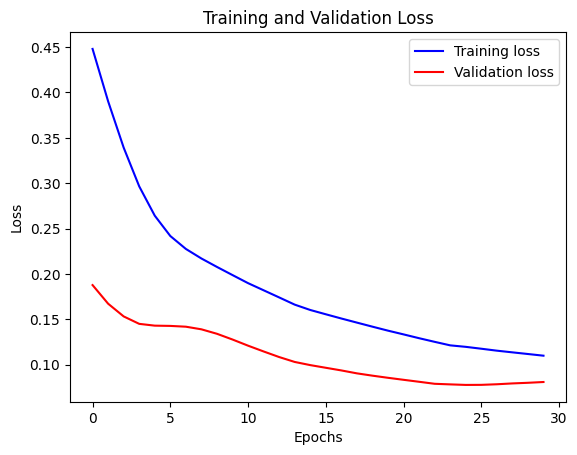

In [54]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [55]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    
    return plt.show()

1/1 [==============================] - 0s 66ms/step


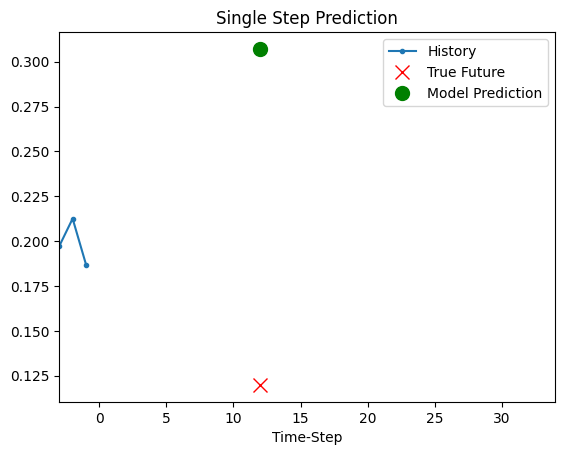

None

In [56]:
for x, y in dataset_val.take(4):
    
    display(show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    ))

In [57]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    sequence_stride=sequence_stride,
    batch_size=batch_size,
)

In [58]:
test_loss = model.evaluate(dataset_test)
test_loss

1/1 [==============================] - 0s 27ms/step - loss: 0.2240


0.22400104999542236

In [59]:
y_pred = np.asarray([model.predict(x).astype(float) for x, y in dataset_test])
y_pred

1/1 [==============================] - 0s 8ms/step


array([[[0.40954718],
        [0.39263418],
        [0.34786421],
        [0.3542532 ]]])

In [60]:
y_hat = list(y_pred.reshape(1, -1)[0])
y_hat

[0.40954717993736267,
 0.39263418316841125,
 0.34786421060562134,
 0.35425320267677307]

In [61]:
[y.numpy().tolist() for x, y in dataset_test][0]

[0.003632779698818922,
 -0.018883856013417244,
 -0.10838775336742401,
 -0.1479845494031906]

In [62]:
inverse_fpi_scale = lambda x: [scalers['fpi'].inverse_transform(np.asarray(p).astype(float).reshape(1, -1))[0][0] for p in x]

In [63]:
model_perf = {country_iso: {'train_mse': history.history['loss'],
                            'train_mse_orig_units': inverse_fpi_scale(history.history['loss']),
                            'val_mse': history.history['val_loss'],
                            'val_mse_orig_units': inverse_fpi_scale(history.history['val_loss']),
                            'test_mse': [test_loss],
                            'test_mse_orig_units': inverse_fpi_scale([test_loss]),
                            'y_test_pred': y_hat,
                            'y_test_pred_orig_units': inverse_fpi_scale(y_hat),
                            'y_test_actual': [y.numpy().tolist() for x, y in dataset_test][0],
                            'y_test_actual_orig_units': inverse_fpi_scale([y.numpy().tolist() for x, y in dataset_test][0]),
                            'lstm_model': params_hash[:8],
                            'lstm_params': model_params,
                            'lstm_checkpoint': checkpoint_filename}}
model_perf

{'SDN': {'train_mse': [0.44790974259376526,
   0.39022713899612427,
   0.33919236063957214,
   0.29651376605033875,
   0.2642083764076233,
   0.24181106686592102,
   0.2275896966457367,
   0.21705229580402374,
   0.20775437355041504,
   0.19878605008125305,
   0.18989679217338562,
   0.1820373833179474,
   0.17417249083518982,
   0.1662323772907257,
   0.16033509373664856,
   0.15560463070869446,
   0.1509421169757843,
   0.146430104970932,
   0.14195190370082855,
   0.13756270706653595,
   0.13344722986221313,
   0.12924784421920776,
   0.1252504140138626,
   0.12137262523174286,
   0.11973121017217636,
   0.11766032129526138,
   0.11552055925130844,
   0.11366544663906097,
   0.1118338331580162,
   0.10998723655939102],
  'train_mse_orig_units': [154.0854080534571,
   141.70447481472362,
   130.75042377892967,
   121.58993521953529,
   114.65594043650354,
   109.84860552323681,
   106.79614560850067,
   104.53440899825588,
   102.53871276575137,
   100.61376126894338,
   98.705780320

In [64]:
with open(files_dir / "models_summary.json", 'r') as f:
    models_summary = json.load(f)

In [65]:
models_summary.update(model_perf)

In [66]:
with open(files_dir / "models_summary.json", 'w') as f:
    json.dump(models_summary, f, sort_keys=True, indent=4)

1/1 [==============================] - 0s 8ms/step


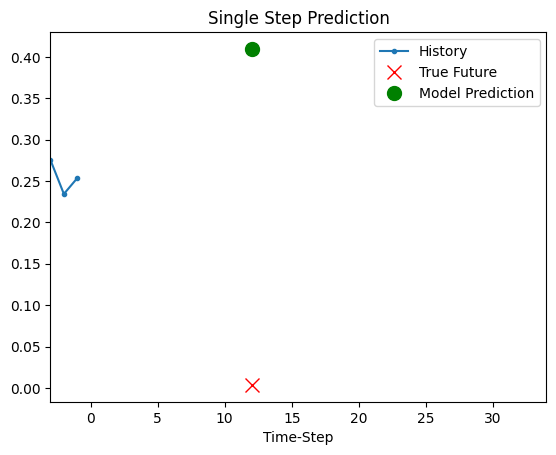

None

In [67]:
for x, y in dataset_test.take(4):
    display(show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    ))

## Env info

In [68]:
# NOTE some dependencies may be missing
# https://github.com/rasbt/watermark/issues/74
%load_ext watermark
%watermark -u -i -m -v -iv --author ewheeler@unicef.org

Author: ewheeler@unicef.org

Last updated: 2023-11-05T19:46:13.061877+03:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

keras     : 2.13.1
joblib    : 1.3.2
json      : 2.0.9
seaborn   : 0.12.2
numpy     : 1.24.1
matplotlib: 3.6.3
plotly    : 5.14.1
skops     : 0.7.post0
pandas    : 2.1.1

